# Miguel Angel Ruiz Ortiz
## Procesamiento de Lenguaje Natural
## Tarea 6: Hierarchical Attention

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
from pathlib import Path
import os
import shutil
import json
import time

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import TweetTokenizer
from bs4 import BeautifulSoup

from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence

# 1) Lectura de corpus y preprocesamiento

In [3]:
base_path = Path("/content/drive/My Drive/Academic Stuff/NLP (CIMAT)")

# carpetas con tweets en xml
train_path = base_path / "corpus" / "2025AuthorProfiling" / "es_train"
val_path = base_path / "corpus" / "2025AuthorProfiling" / "es_val"

# archivos de ground truth
train_truth_path = train_path / "truth.txt"
val_truth_path = val_path / "truth.txt"

# archivos json con todos los tweets por autor
all_train_tweets_path = base_path / "corpus" / "2025AuthorProfiling" / "train_tweets.json"
all_val_tweets_path = base_path / "corpus" / "2025AuthorProfiling" / "val_tweets.json"

# archivo json con mapeo {word -> word_id}
word2id_path = base_path / "models-tarea-6" / "word2id.json"

# carpeta para guardar mejor modelo entrenado
savedir = base_path / "models-tarea-6"
os.makedirs(savedir, exist_ok = True)

In [4]:
df_train = pd.read_csv(train_truth_path, sep=":::", names=["author", "gender", "nationality"])
df_train

<ipython-input-4-456d9087dc1b>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_train = pd.read_csv(train_truth_path, sep=":::", names=["author", "gender", "nationality"])


,author,gender,nationality
0,b06932f4e940fb4a8da35acce4f044c,female,colombia
1,41c28ef7d52cc22e8011800eb9324e2,male,mexico
2,726dc5856c5ed9a10dd8e9f2a5b5ecdd,female,argentina
3,e518e6b3e3770fe3456eda031398c459,female,spain
4,b1daafa3cda99bdacb966afa76859f58,female,colombia
...,...,...,...
3355,4c269442e8eda784f72247df01ea979d,male,argentina
3356,eeba5c9661c4e9fd1c1aad4db24b14cb,male,spain
3357,21898041fd29473e7c23c0731b0c93a8,female,venezuela
3358,49e77eeb8a03fb06983ad69db9e6ca6b,male,peru


In [5]:
df_val = pd.read_csv(val_truth_path, sep=":::", names=["author", "gender", "nationality"])
df_val

<ipython-input-5-563586c5289a>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_val = pd.read_csv(val_truth_path, sep=":::", names=["author", "gender", "nationality"])


,author,gender,nationality
0,2ba09ca56ce61c793805d3e0703b9f7f,female,peru
1,bb7bf5ed6c22e2d067d254ac433ef1a,male,peru
2,cc1c443a2953e18652c92b6697d5fba2,male,argentina
3,a5636a28515fb5d13aacd8eed8c2ef1f,male,venezuela
4,645d5e7d497b5a985841832a9d8ae0dd,female,spain
...,...,...,...
835,1d7947aada81d0ac315550b4ff9c41ed,male,colombia
836,d9028ea9164a22bde5ec3dec8665adae,female,chile
837,33f4e8f49a628d46aa8ccc3645c1980b,female,peru
838,420946a3fd8b4e1ea953fa0f47b2983f,male,argentina


Leemos el dataset de entrenamiento y validación en un diccionario {autor: lista de tweets}, con la ayuda de BeautifulSoup para un fácil manejo de los archivos XML en los que se encuentran los tweets de cada autor. Sólo se realiza una vez la lectura de los archivos XML, y después se escribe cada diccionario en un archivo json para fácil lectura (y más rápida) en diferentes sesiones de trabajo.

In [6]:
if all_train_tweets_path.exists() :
    with open(all_train_tweets_path, "r", encoding="utf-8") as file:
        train_tweets = json.load(file)
else:
    train_tweets = {}

    for author in df_train["author"]:
        with open(train_path / f"{author}.xml", "r") as file:
            soup = BeautifulSoup(file.read(), "xml")

        train_tweets[author] = [doc.get_text() for doc in soup.find_all("document")]

    # writing in json dictionary {author: list of tweets}
    with open(all_train_tweets_path, "w", encoding="utf-8") as file:
        json.dump(train_tweets, file, ensure_ascii=False)

if all_val_tweets_path.exists() :
    with open(all_val_tweets_path, "r", encoding="utf-8") as file:
        val_tweets = json.load(file)
else:
    val_tweets = {}

    for author in df_val["author"]:
        with open(val_path / f"{author}.xml", "r") as file:
            soup = BeautifulSoup(file.read(), "xml")

        val_tweets[author] = [doc.get_text() for doc in soup.find_all("document")]

    # writing in json dictionary {author: list of tweets}
    with open(all_val_tweets_path, "w", encoding="utf-8") as file:
        json.dump(val_tweets, file, ensure_ascii=False)

Ejemplos de cómo se realizó la lectura del dataset:

In [7]:
train_tweets["eeba5c9661c4e9fd1c1aad4db24b14cb"][:5]

['@T_EntrevinoS ,,#vinosporcopas #vinosdiferentes De Lebrija, Solo, 100% Palomino, óptimo https://t.co/aAnDmghKNI',
 '#hortaleza tardes de #invierno https://t.co/J4chUv0idc',
 '@T_EntrevinoS Semonlon 2012 haute-medoc estupendo https://t.co/Dj43vPXo1F',
 '@T_EntrevinoS Mejillones de roca al curry verde espectaculares https://t.co/YhSTxisOme',
 '#EconomiaARV un lumbreras dice que las cifras no mienten..y la otra que el gasto social ha subido. A sueldo de quién están? Periobasurismo']

In [8]:
val_tweets["6b81e745d7df80eeffeee169b6393033"][:5]

['Con toda el martes en Ibagué. Vamos Mechita! 💪👹🅰😈',
 'Y estábamos en casa, no podemos regalar puntos en el Pascual. Tenemos que mejorar mucho. Con toda vamos, sigo confiando en el equipo.',
 'Será hasta el martes ante Tolima en Ibagué. #VamosAmérica',
 'No me gustó el resultado, hubo actitud y lástima que anotamos.',
 'Igual, teníamos que ganar. Entró bien Álvarez. Mucho por mejorar. Se notó la falta de un creativo. ¡UN 10 URGENTE!']

Cargamos los embeddings iniciales:

In [9]:
embeddings_path = base_path / "embeddings" / "word2vec_col.txt"

with open(embeddings_path, "r") as file:
    lines_embeddings_file = file.readlines()

In [10]:
num_words, embedding_dim = map(int, lines_embeddings_file[0].split())
word2embedding = {
    line_splitted[0]: np.array(list(map(float, line_splitted[1:])))
    for line_splitted in map(str.split, lines_embeddings_file[1:])
}

In [11]:
print("Número de palabras con embedding:", num_words)
print("Dimensión de los embeddings:", embedding_dim)

Número de palabras con embedding: 973265
Dimensión de los embeddings: 100


Tokenizamos y utilizamos la misma estructura del diccionario {autor: lista de tweets tokenizados}

In [12]:
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)

train_corpus_tk = {author: [tokenizer.tokenize(tweet) for tweet in train_tweets[author]] for author in train_tweets}
val_corpus_tk = {author: [tokenizer.tokenize(tweet) for tweet in val_tweets[author]] for author in val_tweets}

A continuación veremos la cantidad de palabras en el conjunto de entrenamiento y cuántas de ellas tienen un embedding preentrenado:

In [13]:
train_words = set()
for author in train_corpus_tk:
    for tweet in train_corpus_tk[author]:
        train_words.update(tweet)

print("Número de palabras en el conjunto de entrenamiento:",  len(train_words))

Número de palabras en el conjunto de entrenamiento: 307251


In [14]:
embedddings_words = set(word2embedding.keys())

print("Número de palabras en el conjunto de entrenamiento que también tienen un embedding:", len(train_words.intersection(embedddings_words)))

Número de palabras en el conjunto de entrenamiento que también tienen un embedding: 115841


Definimos el vocabulario como la intersección de las palabras en el conjunto de entrenamiento y las palabras con embedding preentrenado.

In [15]:
vocab = train_words.intersection(embedddings_words)
embeddings = { word: word2embedding[word] for word in vocab }
vocab_len = len(vocab)

Los signos de puntuación no se consideran para el vocabulario:

In [16]:
vocab.intersection({"¡", "!", '"', "$", "%", "&", "'", "(", ")", "*", "+", ",", "-", ".", ":", ";", "¿", "?", "@", "[", "]", "_", "`", "{", "}", "«", "»", "…"})

set()

Guardamos el mapeo {palabra: id de palabra} en un archivo json.

In [17]:
# mapping {word -> word id}
if word2id_path.exists():
    with open(word2id_path, "r", encoding="utf-8") as file:
        word2id = json.load(file)
else:
    # shifted ids to let 0 represent the "pad token"
    word2id = { word: idx+1 for idx, word in enumerate(vocab) }

    with open(word2id_path, "w", encoding="utf-8") as file:
        json.dump(word2id, file, ensure_ascii=False)

In [18]:
id2word = { word2id[word]: word for word in word2id }

Con el mapeo ``{ palabra: id }``, obtenemos la matriz de embeddings preentrenados asociada a nuestro vocabulario. La primera fila la llenamos de 0's, pues el token 0 representa un "token de padding".

In [19]:
embeddings_w = np.array([np.zeros(embedding_dim)]+[embeddings[id2word[i+1]] for i in range(vocab_len)])

In [20]:
embeddings_w.shape

(115842, 100)

Filtramos los tokens fuera del vocabulario, y cada token lo representamos con su correspondiente id. Al filtrar, algunos tweets se quedan sin tokens, i.e., son "tweets vacíos":

In [21]:
def tokenized_tweet_with_ids(tweet: list[str], word2id: dict[str, int]) -> list[int]:
    return [word2id[word] for word in tweet if word in word2id]

In [22]:
X_train_raw = [
    [tokenized_tweet_with_ids(tweet, word2id) for tweet in train_corpus_tk[author]]
    for author in df_train["author"]
]
X_val_raw = [
    [tokenized_tweet_with_ids(tweet, word2id) for tweet in val_corpus_tk[author]]
    for author in df_val["author"]
]

for i in range(len(X_train_raw)):
    tweets_empty = 0
    for tweet in X_train_raw[i]:
        if len(tweet) == 0:
            tweets_empty += 1
    if tweets_empty > 0:
        print(f"Autor {i}: {tweets_empty} tweets vacíos. {tweets_empty/len(X_train_raw[i])*100:.2f}% de tweets")

Autor 1: 1 tweets vacíos. 1.00% de tweets
Autor 6: 1 tweets vacíos. 1.00% de tweets
Autor 12: 1 tweets vacíos. 1.00% de tweets
Autor 13: 1 tweets vacíos. 1.00% de tweets
Autor 34: 1 tweets vacíos. 1.00% de tweets
Autor 36: 1 tweets vacíos. 1.00% de tweets
Autor 38: 1 tweets vacíos. 1.00% de tweets
Autor 43: 1 tweets vacíos. 1.00% de tweets
Autor 44: 1 tweets vacíos. 1.00% de tweets
Autor 48: 3 tweets vacíos. 3.00% de tweets
Autor 62: 1 tweets vacíos. 1.00% de tweets
Autor 63: 1 tweets vacíos. 1.00% de tweets
Autor 64: 1 tweets vacíos. 1.00% de tweets
Autor 65: 1 tweets vacíos. 1.00% de tweets
Autor 66: 4 tweets vacíos. 4.00% de tweets
Autor 72: 1 tweets vacíos. 1.00% de tweets
Autor 73: 2 tweets vacíos. 2.00% de tweets
Autor 78: 1 tweets vacíos. 1.00% de tweets
Autor 80: 1 tweets vacíos. 1.00% de tweets
Autor 81: 1 tweets vacíos. 1.00% de tweets
Autor 85: 1 tweets vacíos. 1.00% de tweets
Autor 87: 1 tweets vacíos. 1.00% de tweets
Autor 90: 1 tweets vacíos. 1.00% de tweets
Autor 94: 1 t

Con los logs anteriores podemos ver que todos los autores tienen mínimo 10 tweets. Quitamos los tweets vacíos:

In [23]:
X_train_raw = [[tweet for tweet in author_tweets if len(tweet) > 0] for author_tweets in X_train_raw]
X_val_raw = [[tweet for tweet in author_tweets if len(tweet) > 0] for author_tweets in X_val_raw]

Los tamaños de las listas de tweets y la longitud de los tweets varía. Entonces creamos un tensor de tamaño ``(num_authors, max_num_tweets, max_tweet_len)``, donde ``num_authors`` es el número de autores, ``max_num_tweets`` es el número máximo de tweets entre los autores, y ``max_tweet_len`` es la longitud máxima entre los tweets. Para lograrlo, rellenamos con 0's, donde 0 va a ser un token de "padding".

In [24]:
max_num_tweets = max(len(author_tweets) for author_tweets in X_train_raw)
max_tweet_len  = max(len(tweet) for author_tweets in X_train_raw for tweet in author_tweets)

print("Máximo número de tweets por autor:", max_num_tweets)
print("Máxima longitud de un tweet:", max_tweet_len)

Máximo número de tweets por autor: 100
Máxima longitud de un tweet: 36


In [25]:
max_num_tweets_val = max(len(author_tweets) for author_tweets in X_val_raw)
max_tweet_len_val  = max(len(tweet) for author_tweets in X_val_raw for tweet in author_tweets)

print("Máximo número de tweets por autor:", max_num_tweets_val)
print("Máxima longitud de un tweet:", max_tweet_len_val)

Máximo número de tweets por autor: 100
Máxima longitud de un tweet: 33


In [26]:
pad_token = 0

In [27]:
X_train = torch.full((len(X_train_raw), max_num_tweets, max_tweet_len), fill_value=pad_token, dtype=torch.int64)
X_val = torch.full((len(X_val_raw), max_num_tweets, max_tweet_len), fill_value=pad_token, dtype=torch.int64)

for i in range(len(X_train)):
    num_tweets = len(X_train_raw[i])
    for j in range(num_tweets):
        X_train[i, j, :len(X_train_raw[i][j])] = torch.tensor(X_train_raw[i][j], dtype=torch.int64)

for i in range(len(X_val)):
    num_tweets = len(X_val_raw[i])
    for j in range(num_tweets):
        X_val[i, j, :len(X_val_raw[i][j])] = torch.tensor(X_val_raw[i][j], dtype=torch.int64)

Ejemplos:

In [28]:
X_train.shape

torch.Size([3360, 100, 36])

In [29]:
X_train[0][0]

tensor([ 65081,  47197,  51919, 115363,  53692,  87137, 109385,  24507,   4906,
         57660,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0])

In [30]:
X_train_raw[0][0]

[65081, 47197, 51919, 115363, 53692, 87137, 109385, 24507, 4906, 57660]

Procesamos las etiquetas/clases:

In [31]:
classes = df_train["nationality"].unique()
classes

array(['colombia', 'mexico', 'argentina', 'spain', 'venezuela', 'peru',
       'chile'], dtype=object)

In [32]:
labels_map = { nation: i for i, nation in enumerate(classes) }
labels_map_inv = {i: nation for nation, i in labels_map.items()}

y_train = torch.tensor([labels_map[nation] for nation in df_train["nationality"]], dtype=torch.int64)
y_val = torch.tensor([labels_map[nation] for nation in df_val["nationality"]], dtype=torch.int64)

# 2) Clasificador basado en RNN + atención jerárquica

El modelo es igual al del artículo de atención jerárquica:

1. Para cada tweet, las palabras pasan por la capa de embedding y se ingresan a una GRU bidireccional. Cada palabra pasa a ser representada por la concatenación de los estados escondidos de la GRU en cada dirección, los estados que se obtienen al procesar esa palabra.
2. Un "vector de contexto" a nivel palabra, con parámtros aprendibles, permite saber la importancia de cada palabra para cada tweet mediante el producto punto con el vector de contexto y mediante softmax. Cada tweet se representa por la suma pesada de las palabras.
3. Dado que cada tweet tiene su representación vectorial obtenida en el punto anterior, se realiza lo mismo que en el punto 1 y 2: los tweets pasan por una GRU bidireccional y cada tweet se representa por la concatenación de los estados escondidos correspondientes, y mediante un vector de contexto a nivel de tweet se le asigna la importancia a cada tweet para discriminar al autor. Teniendo así una representación vectorial para el autor, como la suma pesada de los tweets, el cual es usado para la clasificación final con una capa densa.

Para no tomar en cuenta los tokens de padding, estos tokens se identifican mediante una máscara, la cual permite asignar valores de $-\infty$ a las entradas de la matriz de productos punto con un vector de contexto. De tal manera que al aplicar softmax, estas entradas se vuelven 0.

In [33]:
class Attention(nn.Module):
    def __init__(self, hidden_size: int):
        super().__init__()
        self.hidden_size = hidden_size

        self.W = nn.Linear(hidden_size, hidden_size, bias=True)
        self.u = nn.Parameter(torch.randn(hidden_size))  # context vector

    def forward(self, H: torch.Tensor, mask=None):
        u_it = torch.tanh(self.W(H))  # (batch, position, hidden_size)
        scores = torch.matmul(u_it, self.u)  # (batch, position)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float("-inf"))

        attn_weights = F.softmax(scores, dim=1)  # (batch, position)
        weighted = torch.sum(
            H * attn_weights.unsqueeze(-1), dim=1
        )  # (batch, hidden_size)
        return weighted, attn_weights


class HierarchicalAttentionNetwork(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        word_gru_hidden: int,
        sent_gru_hidden: int,
        num_classes: int,
        pretrained_embeddings: np.ndarray,
        pad_idx: int,
    ):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(pretrained_embeddings, dtype=torch.float),
            freeze=False,
            padding_idx=pad_idx,
        )

        self.word_gru = nn.GRU(
            embed_dim, word_gru_hidden, bidirectional=True, batch_first=True
        )
        self.word_attention = Attention(word_gru_hidden * 2)

        self.sent_gru = nn.GRU(
            word_gru_hidden * 2, sent_gru_hidden, bidirectional=True, batch_first=True
        )
        self.sent_attention = Attention(sent_gru_hidden * 2)

        self.classifier = nn.Linear(sent_gru_hidden * 2, num_classes)

    def forward(self, x: torch.Tensor):
        # x: (batch_size, max_num_tweets, max_tweet_len)
        B, T, W = x.size()
        x_flat = x.view(B * T, W)  # size (B*T, W)
        mask_word = x_flat != self.embedding.padding_idx

        x_emb = self.embedding(x_flat)  # size (B*T, W, E)
        word_outputs, _ = self.word_gru(x_emb)  # size (B*T, W, 2H)
        s_i, word_attn = self.word_attention(
            word_outputs, mask_word
        )  # size (B*T, 2H)

        s_i = s_i.view(B, T, -1)  # size (B, T, 2H)
        mask_sent = x.sum(dim=2) != 0  # (B, T): check "empty tweets"

        sent_outputs, _ = self.sent_gru(s_i)  # size (B, T, 2H)
        v, sent_attn = self.sent_attention(
            sent_outputs, mask_sent
        )  # size (B, 2H)

        # saving attention matrices for analysis
        self.attention_cache = {"word_attn": word_attn, "tweet_attn": sent_attn}

        return self.classifier(v)

Reutilizamos funciones que programó el profesor y que también utilizamos en la tarea pasada

In [34]:
def get_preds(raw_logits: torch.FloatTensor) -> np.ndarray:
    probs = nn.functional.softmax(raw_logits.detach(), dim=1)
    y_pred = torch.argmax(probs, dim=1).cpu().numpy()

    return y_pred

def model_eval(data: DataLoader, model: HierarchicalAttentionNetwork, use_gpu: bool) -> float:
    with torch.no_grad():
        preds, tgts = [], []
        for X_batch, y_batch in data:
            if use_gpu:
                X_batch = X_batch.cuda()

            outputs = model(X_batch)

            # Get prediction
            y_pred = get_preds(outputs)

            tgt = y_batch.numpy()
            tgts.append(tgt)
            preds.append(y_pred)

    tgts = [e for l in tgts for e in l]
    preds = [e for l in preds for e in l]

    return accuracy_score(tgts, preds)

def save_checkpoint(state: dict, is_best: bool, checkpoint_path: Path):
    filename = checkpoint_path / "checkpoint.pt"
    torch.save(state, filename)

    if is_best:
        shutil.copyfile(filename, checkpoint_path / "model_best.pt")

Definimos objetos ``TensorDataset`` y ``DataLoader``

In [35]:
# Dataloader hyperparameters
batch_size = 64
num_workers = 2

# training
train_dataset = TensorDataset(
    X_train, y_train
)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True
)

# validation
val_dataset = TensorDataset(
    X_val, y_val
)

val_loader = DataLoader(
    val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

Hiperparámetros del modelo

In [36]:
# Model hyperparameters
embedding_dim = 100  # Dimension of word embedding
gru_hidden = 64
num_classes = len(labels_map)
pad_idx = -1

# Training hyperparameters
lr = 1e-3
num_epochs = 30
patience = 10

# Scheduler hyperparameters
lr_patience = 5
lr_factor = 0.7

In [37]:
# If GPU available
use_gpu = torch.cuda.is_available()

Entrenamiento del modelo (código adaptado de la tarea anterior y del profesor)

In [55]:
model = HierarchicalAttentionNetwork(
    embed_dim=embedding_dim,
    word_gru_hidden=gru_hidden,
    sent_gru_hidden=gru_hidden,
    num_classes=len(labels_map),
    pretrained_embeddings=embeddings_w,
    pad_idx=pad_idx
)

if use_gpu:
    model.cuda()

In [56]:
# Loss, Optimizer and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, "min",
                patience = lr_patience,
                factor = lr_factor
            )

In [57]:
start_time = time.time()
best_metric = 0
metric_history = []
train_metric_history = []

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    loss_epoch = []
    training_metric = []
    model.train()

    for x_batch, y_batch in train_loader:
        # If GPU available
        if use_gpu:
            x_batch = x_batch.cuda()
            y_batch = y_batch.cuda()

        # Forward pass
        logits = model(x_batch)

        loss = criterion(logits, y_batch)

        loss_epoch.append(loss.item())

        # Get training metrics
        y_pred = get_preds(logits)
        tgt = y_batch.cpu().numpy()
        training_metric.append(accuracy_score(tgt, y_pred))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    # Get metric in validation dataset
    mean_epoch_metric = np.mean(training_metric)
    train_metric_history.append(mean_epoch_metric)

    # Get metric in validation dataset
    model.eval()
    tuning_metric = model_eval(val_loader, model, use_gpu)
    metric_history.append(mean_epoch_metric)

    # Update scheduler
    scheduler.step(tuning_metric)

    # Check for metric improvement
    is_improvement = tuning_metric > best_metric
    if is_improvement:
        best_metric = tuning_metric
        n_no_improve = 0
    else:
        n_no_improve += 1

    # Save best model if metric improved
    save_checkpoint(
      {
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict(),
        'best_metric': best_metric,
      },
      is_improvement,
      savedir
    )

    if n_no_improve >= patience:
        print("No improvement. Breaking out of loop")
        break

    print('Train acc: {}'.format(mean_epoch_metric))
    print('Epoch [{}/{}], Loss: {:.4f} - Val accuracy: {:.4f} - Epoch time: {:.2f}s'.format(
        epoch + 1,
        num_epochs,
        np.mean(loss_epoch),
        tuning_metric,
        time.time() - epoch_start_time
    ))

    print("---%s seconds ---" % (time.time() - start_time))

Train acc: 0.2918632075471698
Epoch [1/30], Loss: 1.8293 - Val accuracy: 0.5726 - Epoch time: 4.46s
---4.458023548126221 seconds ---
Train acc: 0.6423938679245284
Epoch [2/30], Loss: 1.2006 - Val accuracy: 0.6798 - Epoch time: 4.56s
---9.019964218139648 seconds ---
Train acc: 0.7308372641509434
Epoch [3/30], Loss: 0.9122 - Val accuracy: 0.7095 - Epoch time: 4.52s
---13.53921890258789 seconds ---
Train acc: 0.7762382075471698
Epoch [4/30], Loss: 0.7691 - Val accuracy: 0.7476 - Epoch time: 4.49s
---18.033942937850952 seconds ---
Train acc: 0.8130896226415094
Epoch [5/30], Loss: 0.6404 - Val accuracy: 0.7667 - Epoch time: 4.53s
---22.568439483642578 seconds ---
Train acc: 0.8340212264150944
Epoch [6/30], Loss: 0.5597 - Val accuracy: 0.7952 - Epoch time: 4.47s
---27.034196138381958 seconds ---
Train acc: 0.859375
Epoch [7/30], Loss: 0.4827 - Val accuracy: 0.7845 - Epoch time: 3.91s
---30.94699263572693 seconds ---
Train acc: 0.8873820754716981
Epoch [8/30], Loss: 0.3964 - Val accuracy: 0.7

# 3) Rendimiento del modelo

Cargamos el mejor modelo obtenido durante el entrenamiento:

In [38]:
best_model = HierarchicalAttentionNetwork(
    embed_dim=embedding_dim,
    word_gru_hidden=gru_hidden,
    sent_gru_hidden=gru_hidden,
    num_classes=len(labels_map),
    pretrained_embeddings=embeddings_w,
    pad_idx=pad_idx
)
if use_gpu:
    best_model.cuda()
device = torch.device("cuda" if use_gpu else "cpu")
best_model.load_state_dict(torch.load(savedir / "model_best.pt", map_location=device)["state_dict"])
best_model.eval()

HierarchicalAttentionNetwork(
  (embedding): Embedding(115842, 100, padding_idx=115841)
  (word_gru): GRU(100, 64, batch_first=True, bidirectional=True)
  (word_attention): Attention(
    (W): Linear(in_features=128, out_features=128, bias=True)
  )
  (sent_gru): GRU(128, 64, batch_first=True, bidirectional=True)
  (sent_attention): Attention(
    (W): Linear(in_features=128, out_features=128, bias=True)
  )
  (classifier): Linear(in_features=128, out_features=7, bias=True)
)

Evaluamos con el conjunto de validación, imprimiendo el reporte de clasificación dado por Scikit-Learn

In [39]:
with torch.no_grad():
    preds, tgts = [], []
    for X_batch, y_batch in val_loader:
        if use_gpu:
            X_batch = X_batch.cuda()
        outputs = best_model(X_batch)
        y_pred = get_preds(outputs)
        tgt = y_batch.numpy()
        tgts.append(tgt)
        preds.append(y_pred)
    tgts = [e for l in tgts for e in l]
    preds = [e for l in preds for e in l]
    print(classification_report(tgts, preds, target_names=classes))


              precision    recall  f1-score   support

    colombia       0.84      0.82      0.83       120
      mexico       0.84      0.82      0.83       120
   argentina       0.84      0.85      0.85       120
       spain       0.75      0.87      0.80       120
   venezuela       0.85      0.82      0.83       120
        peru       0.79      0.76      0.77       120
       chile       0.90      0.87      0.88       120

    accuracy                           0.83       840
   macro avg       0.83      0.83      0.83       840
weighted avg       0.83      0.83      0.83       840



Visualizamos mediante un mapa de calor la matriz de confunsión (obtenida también con Scikit-Learn).

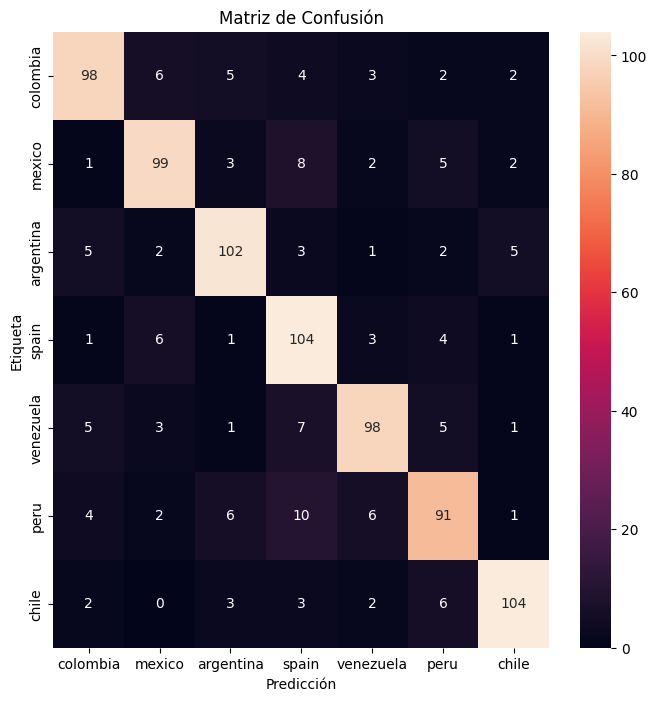

In [40]:
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix(tgts, preds), annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta")
plt.title("Matriz de Confusión")
plt.show()

Se observa que el modelo es muy bueno prediciendo cada clase, obteniendo un f1-score cerca del 80% en todas las clases, y además un accuracy del 83%.

A continuación visualizamos con un mapa de calor algunos scores de atención para autores seleccionados del último batch de la predicción anterior. Dado un autor, se muestran los tweets con score de atención (a nivel tweet) mayor a 0.05. Cada tweet se muestra de manera horizontal, y entre paréntesis se muestra el score asociado al tweet (ver eje y). Cada palabra del tweet tiene su score de atención (a nivel palabra), y el score se visualiza mediante el color del mapa de calor.

In [41]:
X_batch = X_batch.cpu()
y_batch = y_batch.cpu()
word_attn = best_model.attention_cache["word_attn"].cpu()
tweet_attn = best_model.attention_cache["tweet_attn"].cpu()

In [42]:
X_batch.shape, word_attn.shape, tweet_attn.shape

(torch.Size([8, 100, 36]), torch.Size([800, 36]), torch.Size([8, 100]))

In [43]:
def visualize_author(author_idx: int):
    plt.figure(figsize=(20, 5))
    tweets_idx = []
    max_tweet_len_batch = 0

    for i in range(X_batch.shape[1]):
        if tweet_attn[author_idx][i].item() > 0.05:
            tweets_idx.append(i)
            max_tweet_len_batch = max(
                max_tweet_len_batch, len(X_batch[author_idx][i][X_batch[author_idx][i] > 0])
            )

        if len(tweets_idx) == 8:
            break

    sns.heatmap(
        word_attn[[100 * author_idx + i for i in tweets_idx], :max_tweet_len_batch],
        annot=[
            [
                id2word.get(idx.item(), "")
                for idx in X_batch[author_idx][i][:max_tweet_len_batch]
            ]
            for i in tweets_idx
        ],
        fmt="s",
        xticklabels=[f"Palabra {i}" for i in range(max_tweet_len_batch)],
        yticklabels=[
            f"Tweet {i} ({tweet_attn[author_idx][tweets_idx[i]].item():.4f})"
            for i in range(len(tweets_idx))
        ],
        annot_kws={"size": 7},
    )
    plt.xlabel("Palabra")
    plt.ylabel("Tweet")
    plt.title(
        f"Matriz de Atención-Palabra - Etiqueta {labels_map_inv[y_batch[author_idx].item()]}"
    )
    plt.show()

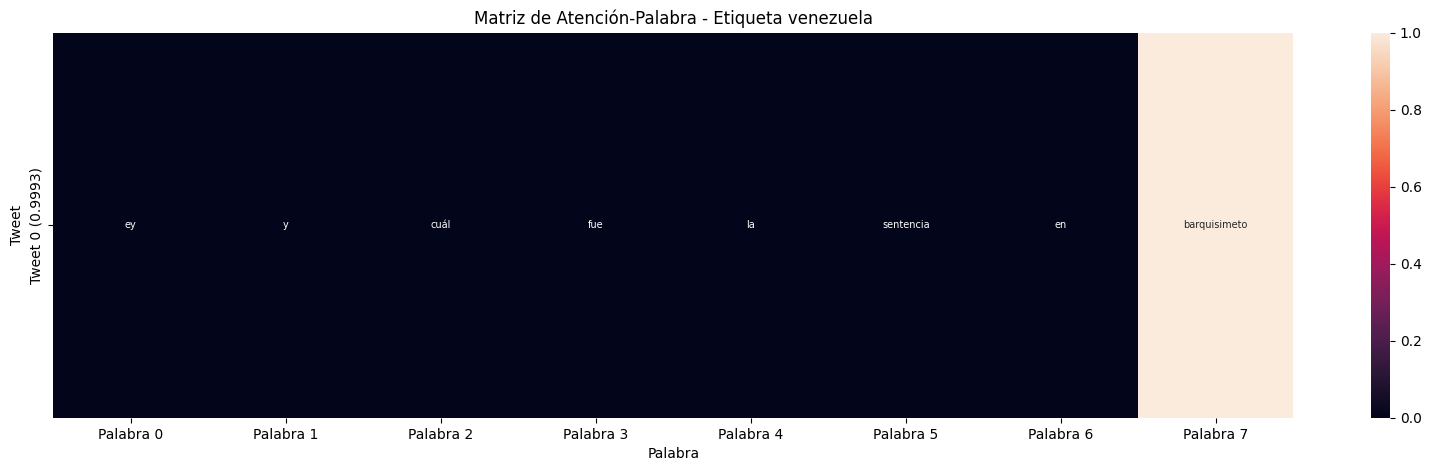

In [44]:
visualize_author(author_idx=0)

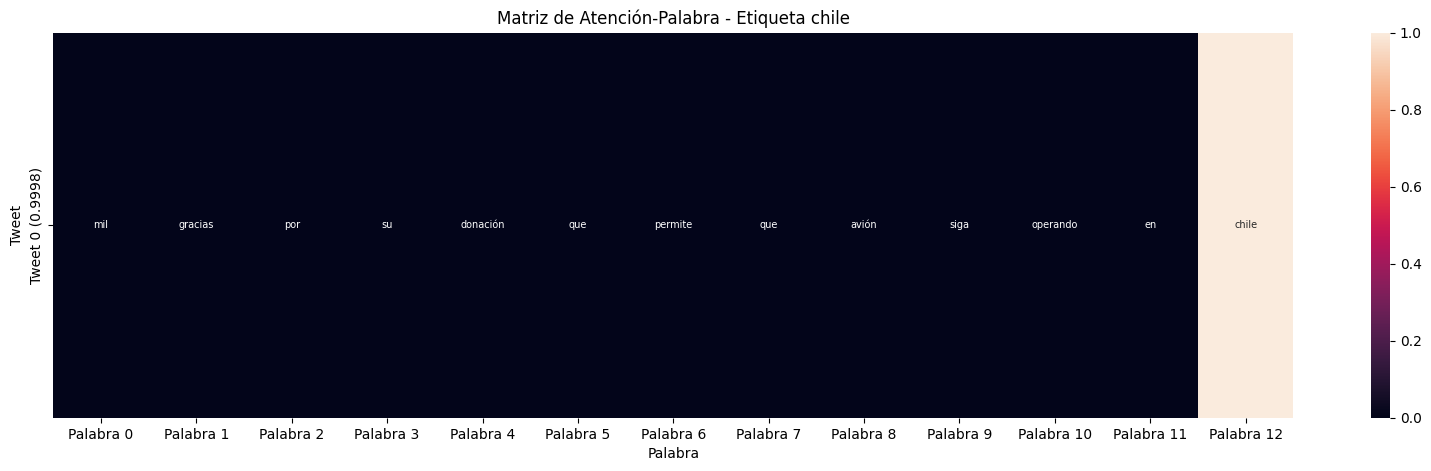

In [45]:
visualize_author(author_idx=4)

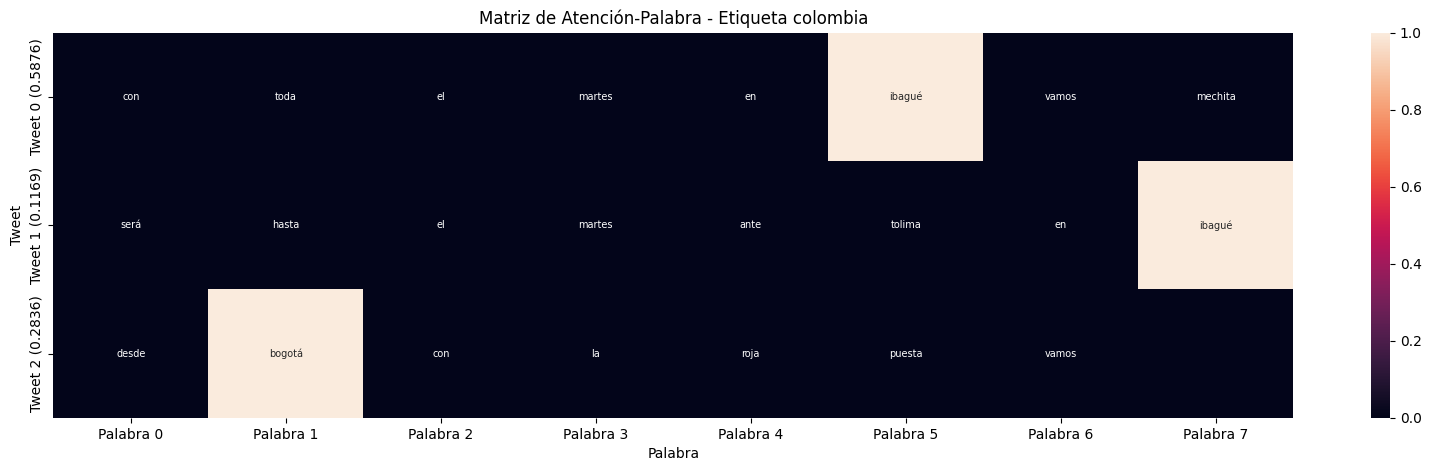

In [46]:
visualize_author(author_idx=7)

En estos 3 ejemplos, vemos cómo los tweets con mayor atención contienen  ciudades del país correspondiente a la etiqueta del autor. Además, estas ciudades tienen un score prácticamente de 1, al igual que los tweets.

# 4) Preguntas

### 4.1) ¿Qué representación de términos uso el profesor para participar? (Consulte http://ceur-ws.org/Vol-1866/paper_109.pdf )

Sea $U_i$ el conjunto de documentos del autor (usuario) $i$, al que se le llama un *usuario-documento*. El profesor utilizó una representación vectorial para $U_i$ basada en en la agregación (i.e., la suma) de las representaciones vectoriales de los términos encontrados en $U_i$. Un término $w$ del vocabulario lo representó como un vector $t=(t_1, \ldots, t_{M})$, donde $M$ es el número de usuarios-documentos en el conjunto de entrenamiento, de tal manera que $t_j$ representa la relevancia del usuario-documento $U_j$ para caracterizar $w$:
$$
t_j := (1+\log(\#(w, U_j)))\cdot \log \frac{M}{N_j},
$$
donde $\#(w, U_j)$ es la frecuencia del término $w$ en $U_j$ y $N_j$ es el número de términos diferentes en el usuario-documento $U_j$.


### 4.2) ¿Qué usó el primer lugar de la competencia? (Basile, et al.) (Consulte: http://ceur-ws.org/Vol-1866/ )

Utilizó una representación tipo Bolsa de Palabras, en las que las features eran $n$-gramas a nivel palabra con $n=1,2$, y $n$-gramas a nivel caracter con $n=3,4, 5$. El peso de cada feature se calculó con TF-IDF, pero con el término de la frecuencia "suavizado" con $1+\log(tf)$, donde $tf$ es la frecuencia.

Estos vectores a nivel de usuario eran clasificados con una máquina de soporte vectorial.

### 4.3)¿Cuántos y que competidores usaron deep learning? En una o dos oraciones escriba qué hicieron: https://ceur-ws.org/Vol-1866/

Para esto sólo me fijé cuáles competidores tenían un trabajo con título relacionado a redes neuronales, y que además el trabajo sea de *Author Profiling*. Encontré los siguientes 5 trabajos:

1.   **Subword-based Deep Averaging Networks for Author Profiling in Social Media**: Utilizaron una variación del modelo *skip-gram continuo* para generar embeddings de palabras. Cada documento se representa con un promedio de las palabras (o bien de sus embeddings) que lo contienen, y mediante una red neuronal se combinan los diferentes documentos del usuario para dar una clasificación al final.
2.   **Convolutional Neural Networks for Author Profiling**: Se concatenan los tweets de un autor y mediante una red neuronal convolucional 1D a nivel de caracter se realiza la clasificación.
3.   **UniNE at CLEF 2017: TF-IDF and Deep-Learning for Author Profiling**: Los documentos de un autor se representan como una matriz tipo Bolsa de Palabras con pesado TF-IDF, en la que las features eran 2-gramas de letras. Esta matriz era alimentada a una red neuronal convolucional para dar la clasificación del autor.
4.   **Author Profiling with Word+Character Neural Attention Network**: En paralelo, las palabras y los caracteres de los tweets de un autor se procesan en 2 diferentes procesos. El proceso para las palabras utiliza una RNN bidireccional con un proceso de atención. El proceso para los caracteres es basado en una red CNN. El resultado de ambos procesos se concatenan y se da una clasificación con capas finales.
5.   **Author Profiling with Bidirectional RNNs using Attention with GRUs**: Se utiliza una GRU bidireccional y un proceso de atención, similar a esta tarea a nivel de palabra.

